In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import fuzzywuzzy as fuzz
#from fuzzywuzzy import process

## Load the data CSVs

In [14]:
# Load full_output.csv
df = pd.read_csv('csv_files/full_output.csv')

# drop unnamed columns
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Load pml_output.csv
pml_df = pd.read_csv('csv_files/pml_output.csv')
pml_df.columns = pml_df.columns.str.strip()

C:\Users\macdk\AppData\Local\Temp\ipykernel_10376\1629307963.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('csv_files/full_output.csv')


## Set variables for filtering

In [15]:
year_list = list(df['Year'].unique())
class_list = list(df['Classification'].unique())
conf_list = list(df['Conference'].unique())

## Functions for analysis

In [16]:
def top_n_grabber(n=20, d=df, y=year_list, cl=class_list, co=conf_list):
    df_grabber = d
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Year.to_list()).isin(y).any(1).values]
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Classification.to_list()).isin(cl).any(1).values]
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Conference.to_list()).isin(co).any(1).values]

    # Select each Selection into a list
    selection_1_list = df_grabber['Selection 1'].tolist()
    selection_2_list = df_grabber['Selection 2'].tolist()
    selection_3_list = df_grabber['Selection 3'].tolist()
    # combine selection 1, 2, and 3 into one dataframe
    full_selection_list = pd.DataFrame(selection_1_list + selection_2_list + selection_3_list)

    top_n_df = pd.DataFrame(full_selection_list.value_counts()[:n])
    top_n_df.columns = ['Count']
    top_n_df.reset_index(drop=False, inplace=True)
    top_n_df.columns = ['Selection', 'Count']
    top_n_df

    # make selection column into a list
    selection_list = top_n_df['Selection'].tolist()
    value_list = top_n_df['Count'].tolist()
    return selection_list, value_list

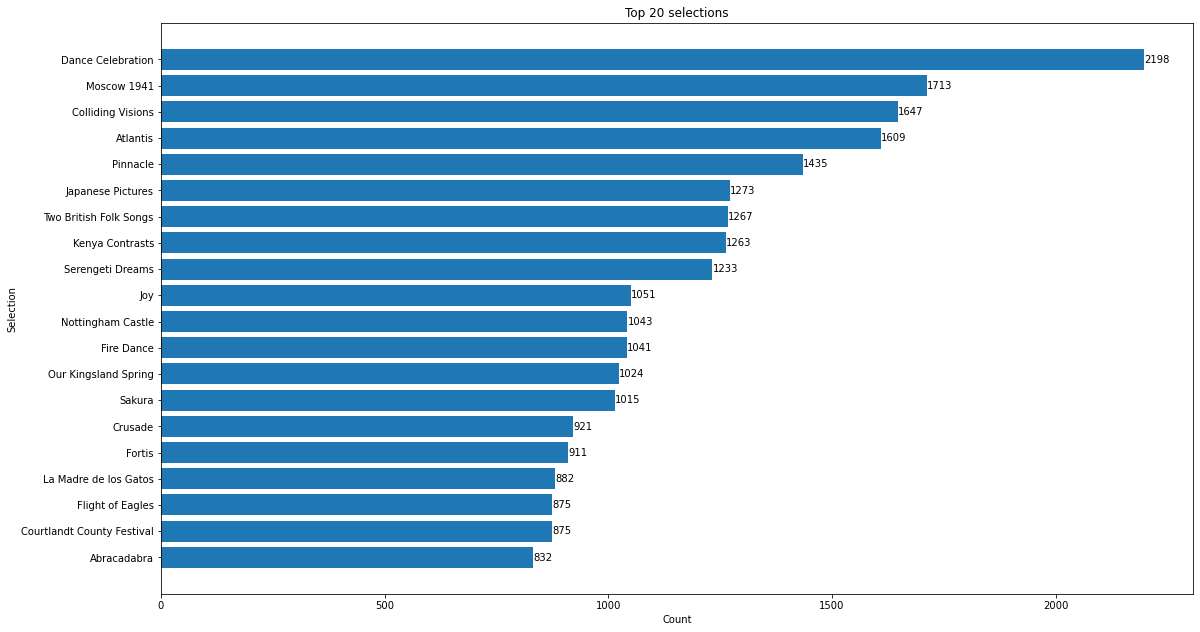

In [17]:
# Plot top n selections
def plotter(n=20, d=df, y=year_list, cl=class_list, co=conf_list):
    fig, ax = plt.subplots()
    bars = ax.barh(top_n_grabber(n, d, y, cl, co)[0], top_n_grabber(n, d, y, cl, co)[1])
    ax.set_title(f'Top {n} selections')
    ax.set_xlabel('Count')
    ax.set_ylabel('Selection')
    for bars in ax.containers:
        ax.bar_label(bars)
    ax.invert_yaxis()
    fig.set_size_inches(18.5, 10.5)

    plt.show()

plotter()

## Find Rows by Selection Title

In [18]:
# Combine all rows where any selection contains the search term
def selection_finder(selection, d=df, y=year_list, cl=class_list, co=conf_list):
    df_grabber = d
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Year.to_list()).isin(y).any(1).values]
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Classification.to_list()).isin(cl).any(1).values]
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Conference.to_list()).isin(co).any(1).values]
    finder_df = df_grabber[(df_grabber['Selection 1'].str.contains(selection)) | (df_grabber['Selection 2'].str.contains(selection)) | (df_grabber['Selection 3'].str.contains(selection))]
    return finder_df

selection = 'Andalucia'
year = [2022]
classification = class_list
conference = conf_list

selection_finder(selection, df, year, class_list, conf_list)

,School,City,Directors,Conference,Classification,Year,Stage Judge 1,Stage Judge 2,Stage Judge 3,Stage Final,...,Selection 3,Date,Region,cj1,cj2,cj3,srj1,srj2,srj3,Stage Average
56208,Blalack MS,Carrollton,Hannah Thiessen / Keith Marshall,CCC,Non-Varsity,2022,1.0,1.0,1.0,1.0,...,Japanese Pictures,04/21/2022,Region: 31,darlene janeski,cindy lansford,dean surface,ramsey macdonald,gloria ramirez,darcy williams,1.000000
56256,Dawson MS,Southlake,Eric Guerrero / Chase Howard,CC,Non-Varsity,2022,1.0,1.0,1.0,1.0,...,Zig Zag,04/21/2022,Region: 31,asa burk,melissa danforth,robert herrings,jennifer alcocer,marty ball,edward pagliai,1.000000
56294,Central JHS,Euless,Elayna Youngson / Christine Cumberledge,BBB,Non-Varsity,2022,1.0,1.0,1.0,1.0,...,Joy,04/21/2022,Region: 31,kim cooley,katie lewis,nathaniel neugent,laura bell,cindy bulloch,ryan heath,1.000000
56371,Kerr MS,Burleson,Brennan Ross / Catharine Klein,CCC,Non-Varsity,2022,1.0,1.0,1.0,1.0,...,Danza de Espana,03/30/2022,Region: 30,eric boulden,shannon dow,ken mclellan,darwert johnson,eleanor macias,cari martin,1.000000
56390,Crowley Middle school,Fort Worth,Marissa Davis / William Lyman,CCC,Varsity,2022,1.0,2.0,2.0,2.0,...,Egyptique,03/30/2022,Region: 30,eric boulden,shannon dow,ken mclellan,darwert johnson,eleanor macias,cari martin,1.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59921,Clint HS,Clint,Anthony Alvarado,AAAA,Non-Varsity,2022,1.0,1.0,1.0,1.0,...,Sketches of Canada,04/26/2022,Region: 22,kathy johnson,bruce collins,shaka hawkins,cassandra tackett,leon steward,anthony rivera,1.000000
59934,Canyon Hills MS,El Paso,Nathan Eby,CC,Non-Varsity,2022,4.0,4.0,4.0,4.0,...,Vulcans Forge,04/12/2022,Region: 22,greg countryman,ross grant,susan glover,michael owen,joshua chessher,guy mckinney,4.000000
59942,Eastwood Knolls,El Paso,John Humphreys / Sal Melendez,CC,Varsity,2022,2.0,1.0,2.0,2.0,...,Synchronized Energy,04/12/2022,Region: 22,greg countryman,ross grant,susan glover,michael owen,joshua chessher,guy mckinney,1.666667
60009,Apollo JH - RISD,Richardson,Andrew Weak,CC,Varsity,2022,1.0,1.0,1.0,1.0,...,Night Fury,03/31/2022,Region: 20,david dunham,ryan heath,nick seibert,john alstrin,evan fletcher,cody russell,1.000000


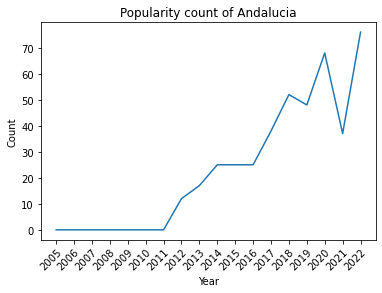

In [19]:
selection = 'Andalucia'
yearly_count_values = []
selection_finder_df = df

for y in year_list:
    selection_finder_df = selection_finder(selection, df, [y], class_list, conf_list)
    yearly_count_values.append(len(selection_finder_df))

def yearly_count_plotter(yearly_count_values):
    fig, ax = plt.subplots()
    ax.plot(yearly_count_values)
    ax.set_title(f'Popularity count of {selection}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    ax.set_xticks(range(len(year_list)))
    ax.set_xticklabels(year_list)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

yearly_count_plotter(yearly_count_values)

# Find Rows by Directors

In [25]:
def director_finder(director, df):
    finder_df = df[df['Directors'].str.contains(director)]
    return finder_df

director = 'Thomas Kober'
df_for_search = df

director_finder_df = director_finder(director, df_for_search)
director_finder_df.sort_values(by='Stage Average', ascending=False)

,School,City,Directors,Conference,Classification,Year,Stage Judge 1,Stage Judge 2,Stage Judge 3,Stage Final,...,Selection 3,Date,Region,cj1,cj2,cj3,srj1,srj2,srj3,Stage Average
38125,William Brennan,San Antonio,"William Kyle Pridgen / Thomas Kober, Mark Wolo...",AAAAAA,Sub Non-Varsity A,2017,2.0,3.0,3.0,3.0,...,Crown of Castille,04/11/2017,Region: 29,roger duran,walter sparkman,bob whipkey,carlos luna,steve snachez,joe menchaca,2.666667
42505,William J. Brennan HS,San Antonio,"Kyle Pridgen / Thomas Kober, Mark Wolocki, Tim...",AAAAAA,Sub Non-Varsity A,2018,3.0,2.0,2.0,2.0,...,Monterey March,04/04/2018,Region: 29,joe menchaca,rolando molina,brian pollard,raul gonzalez,albert salinas,chuck young,2.333333
46468,William J. Brennan HS,San Antonio,"Thomas Kober / Mark Wolocki, William Kyle Prid...",AAAAAA,Sub Non-Varsity,2019,3.0,2.0,2.0,2.0,...,St Petersburg March,04/03/2019,Region: 29,nathan carter,john faraone,albert salazar,rick flores,james snyder,walter sparkman,2.333333
42506,William J. Brennan HS,San Antonio,"Mark Wolocki / Thomas Kober, William Kyle Prid...",AAAAAA,Non-Varsity,2018,2.0,1.0,2.0,2.0,...,Prestissimo,04/04/2018,Region: 29,joe menchaca,rolando molina,brian pollard,raul gonzalez,albert salinas,chuck young,1.666667
46453,William J. Brennan HS,San Antonio,"Mark Wolocki / Thomas Kober, William Kyle Prid...",AAAAAA,Non-Varsity,2019,2.0,2.0,1.0,2.0,...,Overture for Winds,04/03/2019,Region: 29,nathan carter,john faraone,albert salazar,rick flores,james snyder,walter sparkman,1.666667
46469,William J. Brennan HS,San Antonio,"Thomas Kober / Mark Wolocki, William Kyle Prid...",AAAAAA,Varsity,2019,1.0,2.0,2.0,2.0,...,The Melody Shop,04/03/2019,Region: 29,nathan carter,john faraone,albert salazar,rick flores,james snyder,walter sparkman,1.666667
27356,Azle HS,Azle,"Kimberly Murphy / Shawn Murphy, Richard Kearns...",AAAA,Sub Non-Varsity,2014,2.0,1.0,1.0,1.0,...,Choreography,04/08/2014,Region: 2,cindy mikel,mike lipe,rick baker,danny prado,cody newman,keith call,1.333333
27282,Azle HS,Azle,"Kimberly Murphy / Shawn Murphy, Richard Kearns...",AAAA,Non-Varsity,2014,1.0,1.0,1.0,1.0,...,Concord,04/09/2014,Region: 2,cindy mikel,rick baker,mike brady,danny prado,keith call,jeremy strickland,1.000000
27283,Azle HS,Azle,"Shawn Murphy / Thomas Kober, Josh Stover, Rich...",AAAA,Varsity,2014,1.0,1.0,1.0,1.0,...,Florentiner March,04/09/2014,Region: 2,cindy mikel,rick baker,mike brady,danny prado,keith call,jeremy strickland,1.000000
38123,William Brennan,San Antonio,"Mark Wolocki / Thomas Kober, William Kyle Prid...",AAAAAA,Non-Varsity A,2017,1.0,1.0,1.0,1.0,...,Alamo March,04/11/2017,Region: 29,roger duran,walter sparkman,bob whipkey,carlos luna,steve snachez,joe menchaca,1.000000


In [21]:
director_score = director_finder_df['Stage Average'].mean()
director_score

1.3174603174603174

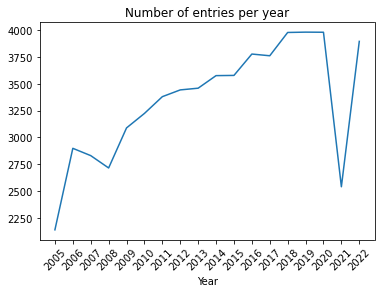

In [22]:
# Plot a line graph of the number of rows in each year
df_year_counter = df.groupby('Year').size()
df_year_counter.plot(kind='line')
plt.xticks(year_list)
plt.xticks(rotation=45)
plt.title('Number of entries per year')
plt.show()

In [23]:
stage_judge_name_columns = ['cj1', 'cj2', 'cj3']
sr_judge_name_columns = ['srj1', 'srj2', 'srj3']

cj1_list = df['cj1'].to_list()
cj2_list = df['cj2'].to_list()
cj3_list = df['cj3'].to_list()
srj1_list = df['srj1'].to_list()
srj2_list = df['srj2'].to_list()
srj3_list = df['srj3'].to_list()

all_stage_judges_list = cj1_list + cj2_list + cj3_list
stage_judge_unique = list(set(all_stage_judges_list))


all_sr_judges_list = srj1_list + srj2_list + srj3_list
sr_judge_unique = list(set(all_sr_judges_list))

all_list = all_stage_judges_list + all_sr_judges_list
all_unique = list(set(all_list))

